In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from mocap_labels import WALK_TRIALS, RUN_TRIALS, __walk_trials, __run_trials

Training GPDM for subject 7 trial 12...


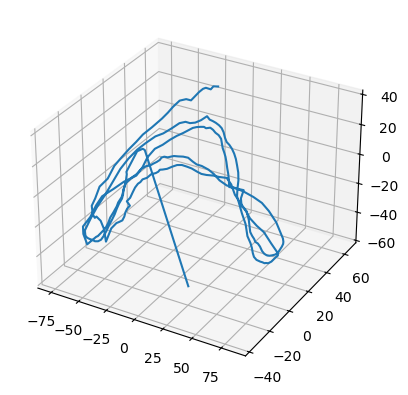

Training GPDM for subject 2 trial 2...


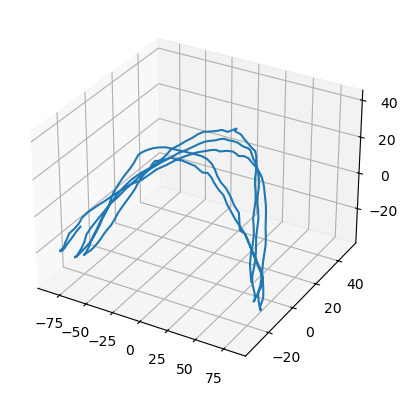

Training GPDM for subject 7 trial 11...


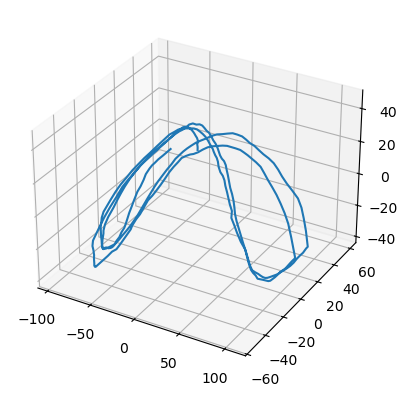

Training GPDM for subject 7 trial 2...


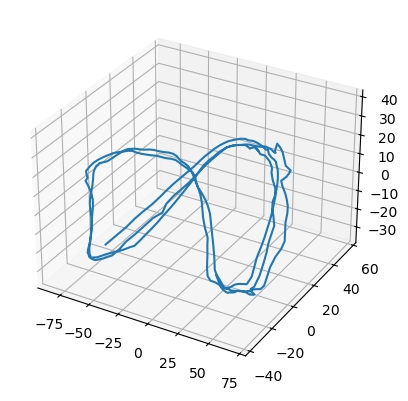

Training GPDM for subject 7 trial 6...


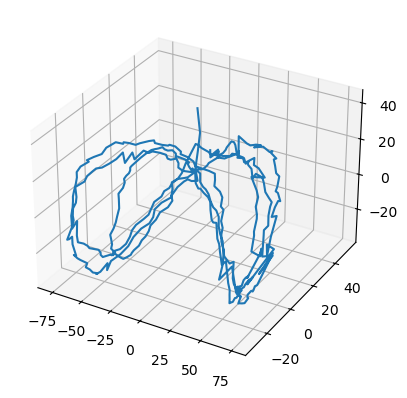

In [6]:
from gpdm_marginalized import GPDM_Marginalized

# Select 5 random trials and train a GPDM for each
# Then, plot the latent space for each trial

random_walk_mocaps = random.sample(WALK_TRIALS, 5)

walking_gpdm_trajectories = []
for mocap in random_walk_mocaps:

    print(f"Training GPDM for subject {mocap.subject} trial {mocap.trial}...")

    arr = mocap.as_dataframe().drop(columns=['time', 'frame']).to_numpy().astype(np.float64)
    gpdm = GPDM_Marginalized(arr, 3)
    gpdm.fit()
    latent_trajectory = gpdm.X_map
  
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(latent_trajectory[:, 0], latent_trajectory[:, 1], latent_trajectory[:, 2])
    plt.show()




Training GPDM for subject 35 trial 20...


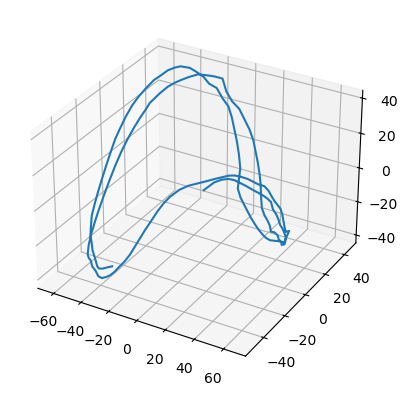

Training GPDM for subject 9 trial 7...


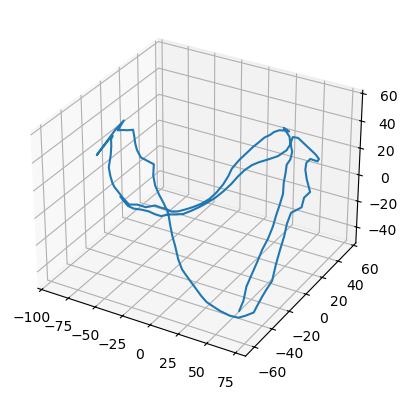

Training GPDM for subject 16 trial 46...


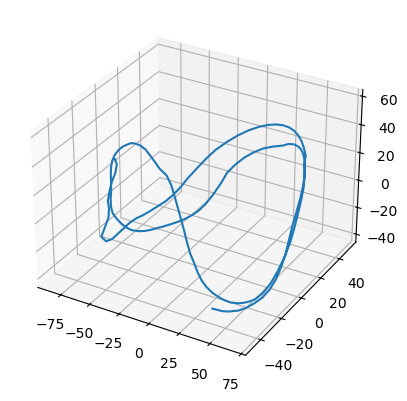

Training GPDM for subject 35 trial 18...


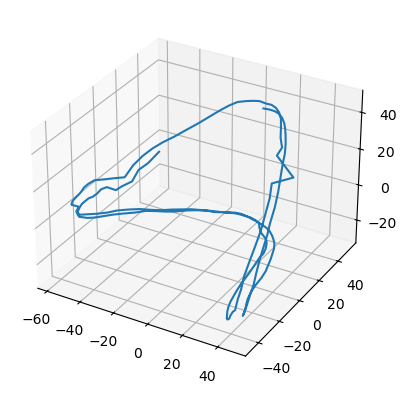

Training GPDM for subject 16 trial 45...


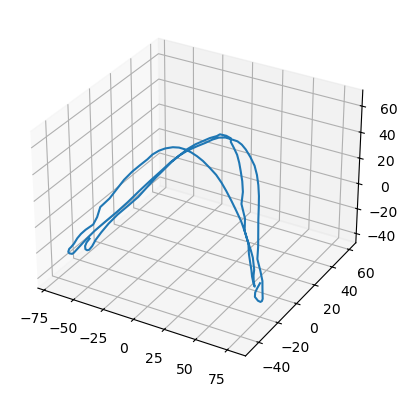

In [7]:
# Repeat for running trials

random_run_mocaps = random.sample(RUN_TRIALS, 5)

running_gpdm_trajectories = []
for mocap in random_run_mocaps:

    print(f"Training GPDM for subject {mocap.subject} trial {mocap.trial}...")

    arr = mocap.as_dataframe().drop(columns=['time', 'frame']).to_numpy().astype(np.float64)
    gpdm = GPDM_Marginalized(arr, 3)
    gpdm.fit()
    latent_trajectory = gpdm.X_map
  
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(latent_trajectory[:, 0], latent_trajectory[:, 1], latent_trajectory[:, 2])
    plt.show()
